## Загрузка библиотек

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error

## Загрузка и предобработка данных

In [ ]:
df = pd.read_json("sber.json")
df.head()

,date,close,open,low,high,trendclspr,volume,value,numtrades
0,2022-03-28,125.00,130.60,125.00,131.47,-4.94,33212430,4.203875e+09,121793
1,2022-03-29,128.77,126.16,122.00,137.57,3.02,72338740,9.470337e+09,184608
2,2022-03-30,134.60,136.89,131.11,138.40,4.53,35675450,4.754054e+09,102479
3,2022-03-31,143.69,135.25,134.52,147.41,6.75,118425000,1.666945e+10,255603
4,2022-04-01,154.50,145.00,144.51,155.40,7.52,118880720,1.802233e+10,265276


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066 entries, 0 to 1065
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1066 non-null   datetime64[ns]
 1   close       1066 non-null   float64       
 2   open        1066 non-null   float64       
 3   low         1066 non-null   float64       
 4   high        1066 non-null   float64       
 5   trendclspr  1066 non-null   float64       
 6   volume      1066 non-null   int64         
 7   value       1066 non-null   float64       
 8   numtrades   1066 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 75.1 KB


In [ ]:
df.isna().sum()

,0
date,0
close,0
open,0
low,0
high,0
trendclspr,0
volume,0
value,0
numtrades,0


In [ ]:
# Добавляем временные признаки
df["dayofweek"] = df["date"].dt.dayofweek
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["day_of_year"] = df["date"].dt.dayofyear
df.head()

,date,close,open,low,high,trendclspr,volume,value,numtrades,dayofweek,month,day,day_of_year
0,2022-03-28,125.00,130.60,125.00,131.47,-4.94,33212430,4.203875e+09,121793,0,3,28,87
1,2022-03-29,128.77,126.16,122.00,137.57,3.02,72338740,9.470337e+09,184608,1,3,29,88
2,2022-03-30,134.60,136.89,131.11,138.40,4.53,35675450,4.754054e+09,102479,2,3,30,89
3,2022-03-31,143.69,135.25,134.52,147.41,6.75,118425000,1.666945e+10,255603,3,3,31,90
4,2022-04-01,154.50,145.00,144.51,155.40,7.52,118880720,1.802233e+10,265276,4,4,1,91


In [ ]:
df['range'] = df['high'] - df['low']
df['body'] = df['close'] - df['open']
df['pct_change'] = df['close'].pct_change() #
df['volume_change'] = df['volume'].pct_change()
df['value_change'] = df['value'].pct_change()


# Скользящие
for window in [3, 7]:
    df[f'close_mean_{window}'] = df['close'].rolling(window).mean()
    df[f'close_std_{window}'] = df['close'].rolling(window).std()

# Лаги
for lag in [1, 5, 7, 14, 21]:
    df[f'lag_{lag}'] = df['close'].shift(lag)


df = df.dropna()
df.head()

,date,close,open,low,high,trendclspr,volume,value,numtrades,dayofweek,...,value_change,close_mean_3,close_std_3,close_mean_7,close_std_7,lag_1,lag_5,lag_7,lag_14,lag_21
21,2022-04-26,122.36,112.58,111.90,124.92,9.35,83540530,9.832906e+09,172772,1,...,0.898571,117.076667,5.230816,119.361429,4.010218,111.90,120.30,130.88,141.60,125.00
22,2022-04-27,131.11,123.00,120.60,131.73,7.15,115500050,1.483238e+10,218386,2,...,0.508443,121.790000,9.617676,120.398571,5.871443,122.36,121.50,123.85,147.50,128.77
23,2022-04-28,123.85,132.14,123.05,134.50,-5.54,123541890,1.600738e+10,245162,3,...,0.079219,125.773333,4.681350,120.905714,6.013116,131.11,118.65,120.30,143.72,134.60
24,2022-04-29,128.80,123.67,122.80,130.00,4.00,87366110,1.107590e+10,183569,4,...,-0.308075,127.920000,3.709137,121.948571,6.724323,123.85,116.97,121.50,138.69,143.69
25,2022-05-04,123.20,129.10,122.50,131.50,-4.35,67289000,8.444076e+09,168134,2,...,-0.237617,125.283333,3.062815,122.598571,6.570478,128.80,111.90,118.65,135.38,154.50


In [ ]:
df = df.set_index('date')
df.head()

,close,open,low,high,trendclspr,volume,value,numtrades,dayofweek,month,...,value_change,close_mean_3,close_std_3,close_mean_7,close_std_7,lag_1,lag_5,lag_7,lag_14,lag_21
date,,,,,,,,,,,,,,,,,,,,,
2022-04-26,122.36,112.58,111.90,124.92,9.35,83540530,9.832906e+09,172772,1,4,...,0.898571,117.076667,5.230816,119.361429,4.010218,111.90,120.30,130.88,141.60,125.00
2022-04-27,131.11,123.00,120.60,131.73,7.15,115500050,1.483238e+10,218386,2,4,...,0.508443,121.790000,9.617676,120.398571,5.871443,122.36,121.50,123.85,147.50,128.77
2022-04-28,123.85,132.14,123.05,134.50,-5.54,123541890,1.600738e+10,245162,3,4,...,0.079219,125.773333,4.681350,120.905714,6.013116,131.11,118.65,120.30,143.72,134.60
2022-04-29,128.80,123.67,122.80,130.00,4.00,87366110,1.107590e+10,183569,4,4,...,-0.308075,127.920000,3.709137,121.948571,6.724323,123.85,116.97,121.50,138.69,143.69
2022-05-04,123.20,129.10,122.50,131.50,-4.35,67289000,8.444076e+09,168134,2,5,...,-0.237617,125.283333,3.062815,122.598571,6.570478,128.80,111.90,118.65,135.38,154.50


In [ ]:
df.dropna(inplace=True)
feature_cols = [col for col in df.columns if col != 'close']
target_col = 'close'

train, test = train_test_split(df, train_size=0.8, shuffle=False)
X_train, y_train = train[feature_cols], train[target_col]
X_test, y_test = test[feature_cols], test[target_col]

In [ ]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,dayofweek,month,year,day,day_of_year,lag_1,lag_2,lag_3,lag_6,lag_24
Datetime,,,,,,,,,,,,,,,,,,
2006-12-17 17:00:00,3.406767,0.166633,234.229833,14.510000,0.0,0.466667,16.816667,17,6,12,2006,17,351,3.326033,2.985400,2.092633,2.471000,4.222889
2006-12-17 18:00:00,3.697100,0.135067,234.372333,15.750000,0.0,0.000000,16.833333,18,6,12,2006,17,351,3.406767,3.326033,2.985400,1.915867,3.632200
2006-12-17 19:00:00,2.908400,0.265167,233.195667,12.516667,0.0,0.516667,16.683333,19,6,12,2006,17,351,3.697100,3.406767,3.326033,1.660767,3.400233
2006-12-17 20:00:00,3.361500,0.271500,236.426500,14.276667,0.0,1.116667,17.116667,20,6,12,2006,17,351,2.908400,3.697100,3.406767,2.092633,3.268567
2006-12-17 21:00:00,3.040767,0.267967,239.104167,12.716667,0.0,1.200000,17.500000,21,6,12,2006,17,351,3.361500,2.908400,3.697100,2.985400,3.056467


## Поиск параметров лучшей модели

In [ ]:
from xgboost import XGBRegressor
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2],
# }

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1],  # regularization
    'reg_alpha': [0, 0.1],  # L1
    'reg_lambda': [1, 5]    # L2
}

model = XGBRegressor(random_state=42, enable_categorical=False, objective='reg:squarederror', n_jobs=-1)

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",  # <== устойчивая метрика
    cv=3,
    verbose=2,
    n_jobs=-1
)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Best params:", grid.best_params_)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
Best params: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 5, 'subsample': 0.8}


## Прогноз + визуализация

In [ ]:
y_pred = best_model.predict(X_test)
y_pred_last_10 = y_pred[-10:]
y_test_last_10 = y_test[-10:]


Метрики:
MSE: 3.576
MAE: 1.300
RMSE: 1.891
R²: 0.994
MAPE: 0.005


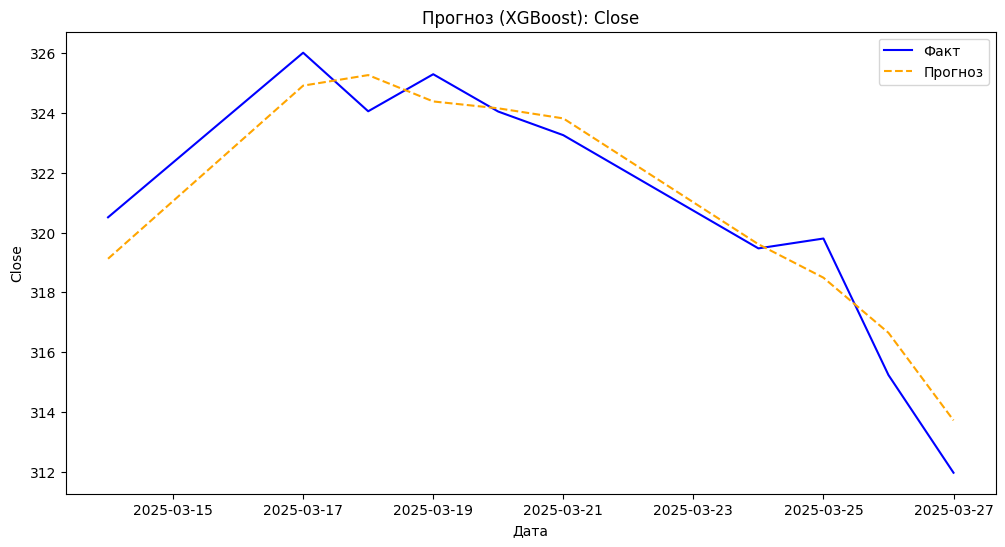

In [ ]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"\nМетрики:")
print(f"MSE: {mse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")
print(f"MAPE: {mape:.3f}")

plt.figure(figsize=(12,6))
plt.plot(y_test_last_10.index, y_test_last_10, label="Факт", color='blue')
plt.plot(y_test_last_10.index, y_pred_last_10, label="Прогноз", linestyle="dashed", color='orange')
plt.legend()
plt.xlabel("Дата")
plt.ylabel("Close")
plt.title("Прогноз (XGBoost): Close")
plt.show()